# Content-aware image restoration

Fluorescence microscopy is constrained by the microscope's optics, fluorophore chemistry, and the sample's photon tolerance. These constraints require balancing imaging speed, resolution, light exposure, and depth. CARE demonstrates how Deep learning can extend the range of biological phenomena observable by microscopy when any of these factor becomes limiting.

**Reference**: Weigert, et al. "Content-aware image restoration: pushing the limits of fluorescence microscopy." Nature methods 15.12 (2018): 1090-1097. doi:[10.1038/s41592-018-0216-7](https://www.nature.com/articles/s41592-018-0216-7)


### CARE

In this first exercise we will train a CARE model for a 2D denoising task. CARE stands for Content-Aware image REstoration, and is a supervised method in which we use pairs of degraded and high quality image to train a particular task. The original paper demonstrated improvement of image quality on a variety of tasks such as image restoration or resolution improvement. Here, we will apply CARE to denoise images acquired at low laser power in order to recover the biological structures present in the data!

<p align="center">
    <img src="nb_data/img_intro.png" alt="Denoising task" class="center"> 
</p>

We'll use the UNet model that we built in the semantic segmentation exercise and use a different set of functions to train the model for restoration rather than segmentation.


<div class="alert alert-block alert-success"><h3>Objectives</h3>
    
- Train a UNet on a new task!
- Understand how to train CARE
  
</div>



 

### Mandatory actions
<div class="alert alert-danger">
Set your python kernel to <code>02_regression</code> <br>
</div>

In [16]:
from careamics_portfolio import PortfolioManager
import tifffile
import numpy as np
from pathlib import Path
from typing import Union, List, Tuple
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch import no_grad, cuda
from transforms import augment_batch, normalize, denormalize
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

<hr style="height:2px;">

## Part 1: Set-up the data

CARE is a fully supervised algorithm, therefore we need image pairs for training. In practice this is best achieved by acquiring each image twice, once with short exposure time or low laser power to obtain a noisy low-SNR (signal-to-noise ratio) image, and once with high SNR.

Here, we will be using high SNR images of Human U2OS cells taken from the Broad Bioimage Benchmark Collection ([BBBC006v1](https://bbbc.broadinstitute.org/BBBC006)). The low SNR images were created by synthetically adding strong read-out and shot noise, and applying pixel binning of 2x2, thus mimicking acquisitions at a very low light level.

Since the image pairs were synthetically created in this example, they are already aligned perfectly. Note that when working with real paired acquisitions, the low and high SNR images are not pixel-perfect aligned so they would often need to be co-registered before training a CARE model.

## Download the data

To download the data, we use the careamics-portfolio package. The package provides a collection of microscopy datasets and convenience functions for downloading them.

In [17]:
# Download the data
portfolio = PortfolioManager()
print(portfolio.denoising)

root_path = Path("/localscratch/data")
files = portfolio.denoising.CARE_U2OS.download(root_path)
print(f"Number of files downloaded: {len(files)}")

denoising datasets: ['N2N_SEM', 'N2V_BSD68', 'N2V_SEM', 'N2V_RGB', 'Flywing', 'Convallaria', 'CARE_U2OS']
Number of files downloaded: 6148


### Split the dataset into training and validation


In [18]:
# Define the paths
root_path = root_path / "denoising-CARE_U2OS.unzip" / "data" / "U2OS"
assert root_path.exists(), f"Path {root_path} does not exist"

train_images_path = root_path / "train" / "low"
train_targets_path = root_path / "train" / "GT"
test_image_path = root_path / "test" / "low"
test_target_path = root_path / "test" / "GT"


image_files = list(Path(train_images_path).rglob("*.tif"))
target_files = list(Path(train_targets_path).rglob("*.tif"))
assert len(image_files) == len(
    target_files
), "Number of images and targets do not match"

print(f"Total size of train dataset: {len(image_files)}")

# Split the train data into train and validation
seed = 42
train_files_percentage = 0.8
np.random.seed(seed)
shuffled_indices = np.random.permutation(len(image_files))
image_files = np.array(image_files)[shuffled_indices]
target_files = np.array(target_files)[shuffled_indices]
assert all(
    [i.name == j.name for i, j in zip(image_files, target_files)]
), "Files do not match"

train_image_files = image_files[: int(train_files_percentage * len(image_files))]
train_target_files = target_files[: int(train_files_percentage * len(target_files))]
val_image_files = image_files[int(train_files_percentage * len(image_files)) :]
val_target_files = target_files[int(train_files_percentage * len(target_files)) :]
assert all(
    [i.name == j.name for i, j in zip(train_image_files, train_target_files)]
), "Train files do not match"
assert all(
    [i.name == j.name for i, j in zip(val_image_files, val_target_files)]
), "Val files do not match"

print(f"Train dataset size: {len(train_image_files)}")
print(f"Validation dataset size: {len(val_image_files)}")

# Read the test files
test_image_files = list(test_image_path.rglob("*.tif"))
test_target_files = list(test_target_path.rglob("*.tif"))
print(f"Number of test files: {len(test_image_files)}")

Total size of train dataset: 2457
Train dataset size: 1965
Validation dataset size: 492
Number of test files: 615


### Patching function

In the majority of cases microscopy images are too large to be processed at once and need to be divided into smaller patches. We will define a function that takes image and target arrays and extract random (paired) patches from them.

The method is a bit scary because accessing the whole patch coordinates requires some magical python expressions. 


In [19]:
def create_patches(
    image_array: np.ndarray,
    target_array: np.ndarray,
    patch_size: Union[List[int], Tuple[int, ...]],
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create random patches from an array and a target.

    The method calculates how many patches the image can be divided into and then
    extracts an equal number of random patches.

    Important: the images should have an extra dimension before the spatial dimensions.
    if you try it with only 2D or 3D images, don't forget to add an extra dimension
    using `image = image[np.newaxis, ...]`
    """
    # random generator
    rng = np.random.default_rng()
    image_patches = []
    target_patches = []

    # iterate over the number of samples in the input array
    for s in range(image_array.shape[0]):
        # calculate the number of patches we can extract
        sample = image_array[s]
        target_sample = target_array[s]
        n_patches = np.ceil(np.prod(sample.shape) / np.prod(patch_size)).astype(int)
        
        # iterate over the number of patches
        for _ in range(n_patches):
            # get random coordinates for the patch and create the crop coordinates
            crop_coords = [
                rng.integers(0, sample.shape[i] - patch_size[i], endpoint=True)
                for i in range(len(patch_size))
            ]

            # extract patch from the data
            patch = (
                sample[
                    (
                        ...,  
                        *[ 
                            slice(c, c + patch_size[i])
                            for i, c in enumerate(crop_coords)
                        ],
                    )
                ]
                .copy()
                .astype(np.float32)
            )

            # same for the target patch
            target_patch = (
                target_sample[
                    (
                        ...,  
                        *[ 
                            slice(c, c + patch_size[i])
                            for i, c in enumerate(crop_coords)
                        ],
                    )
                ]
                .copy()
                .astype(np.float32)
            )
            
            # add the patch pair to the list
            image_patches.append(patch)
            target_patches.append(target_patch)
    
    # return stack of patches
    return np.stack(image_patches), np.stack(target_patches)

<div class="alert alert-block alert-info"><h3>Task 1: Patch creation</h3>

Use a `numpy` array to check that the patching function creates random patches in the image.

*hint: you can use `np.arange(5*5).reshape(25)[np.newaxis, ...]` to create ordered arrays and call the patching function on them.*
</div>

In [20]:
# your code here
n = 5
image_array = np.arange(n*n).reshape((n, n))[np.newaxis, ...]
target_array = np.arange(n*n).reshape((n, n))[np.newaxis, ...]

image_patches, target_patches = create_patches(image_array, target_array, patch_size=(2, 2))
for ind in range(image_patches.shape[0]):
    assert (image_patches[ind] == target_patches[ind]).all()
    print(image_patches[ind])

[[3. 4.]
 [8. 9.]]
[[10. 11.]
 [15. 16.]]
[[ 6.  7.]
 [11. 12.]]
[[12. 13.]
 [17. 18.]]
[[ 7.  8.]
 [12. 13.]]
[[13. 14.]
 [18. 19.]]
[[ 8.  9.]
 [13. 14.]]


### Create patches

To train the network, we will use patches of size 128x128. We first need to load the data, stack it and then call our patching function.

In [21]:
# Load images and stack them into arrays
train_images_array = np.stack([tifffile.imread(str(f)) for f in train_image_files])
train_targets_array = np.stack([tifffile.imread(str(f)) for f in train_target_files])
val_images_array = np.stack([tifffile.imread(str(f)) for f in val_image_files])
val_targets_array = np.stack([tifffile.imread(str(f)) for f in val_target_files])

test_images_array = np.stack([tifffile.imread(str(f)) for f in test_image_files])
test_targets_array = np.stack([tifffile.imread(str(f)) for f in test_target_files])


print(f"Train images array shape: {train_images_array.shape}")
print(f"Validation images array shape: {val_images_array.shape}")
print(f"Test array shape: {test_images_array.shape}")

Train images array shape: (1965, 256, 256)
Validation images array shape: (492, 256, 256)
Test array shape: (615, 256, 256)


In [22]:
# Create patches
patch_size = (128, 128)

train_images_patches, train_targets_patches = create_patches(
    train_images_array, train_targets_array, patch_size
)
assert (
    train_images_patches.shape[0] == train_targets_patches.shape[0]
), "Number of patches do not match"

val_images_patches, val_targets_patches = create_patches(
    val_images_array, val_targets_array, patch_size
)
assert (
    val_images_patches.shape[0] == val_targets_patches.shape[0]
), "Number of patches do not match"

print(f"Train images patches shape: {train_images_patches.shape}")
print(f"Validation images patches shape: {val_images_patches.shape}")

Train images patches shape: (7860, 128, 128)
Validation images patches shape: (1968, 128, 128)


### Visualize training patches

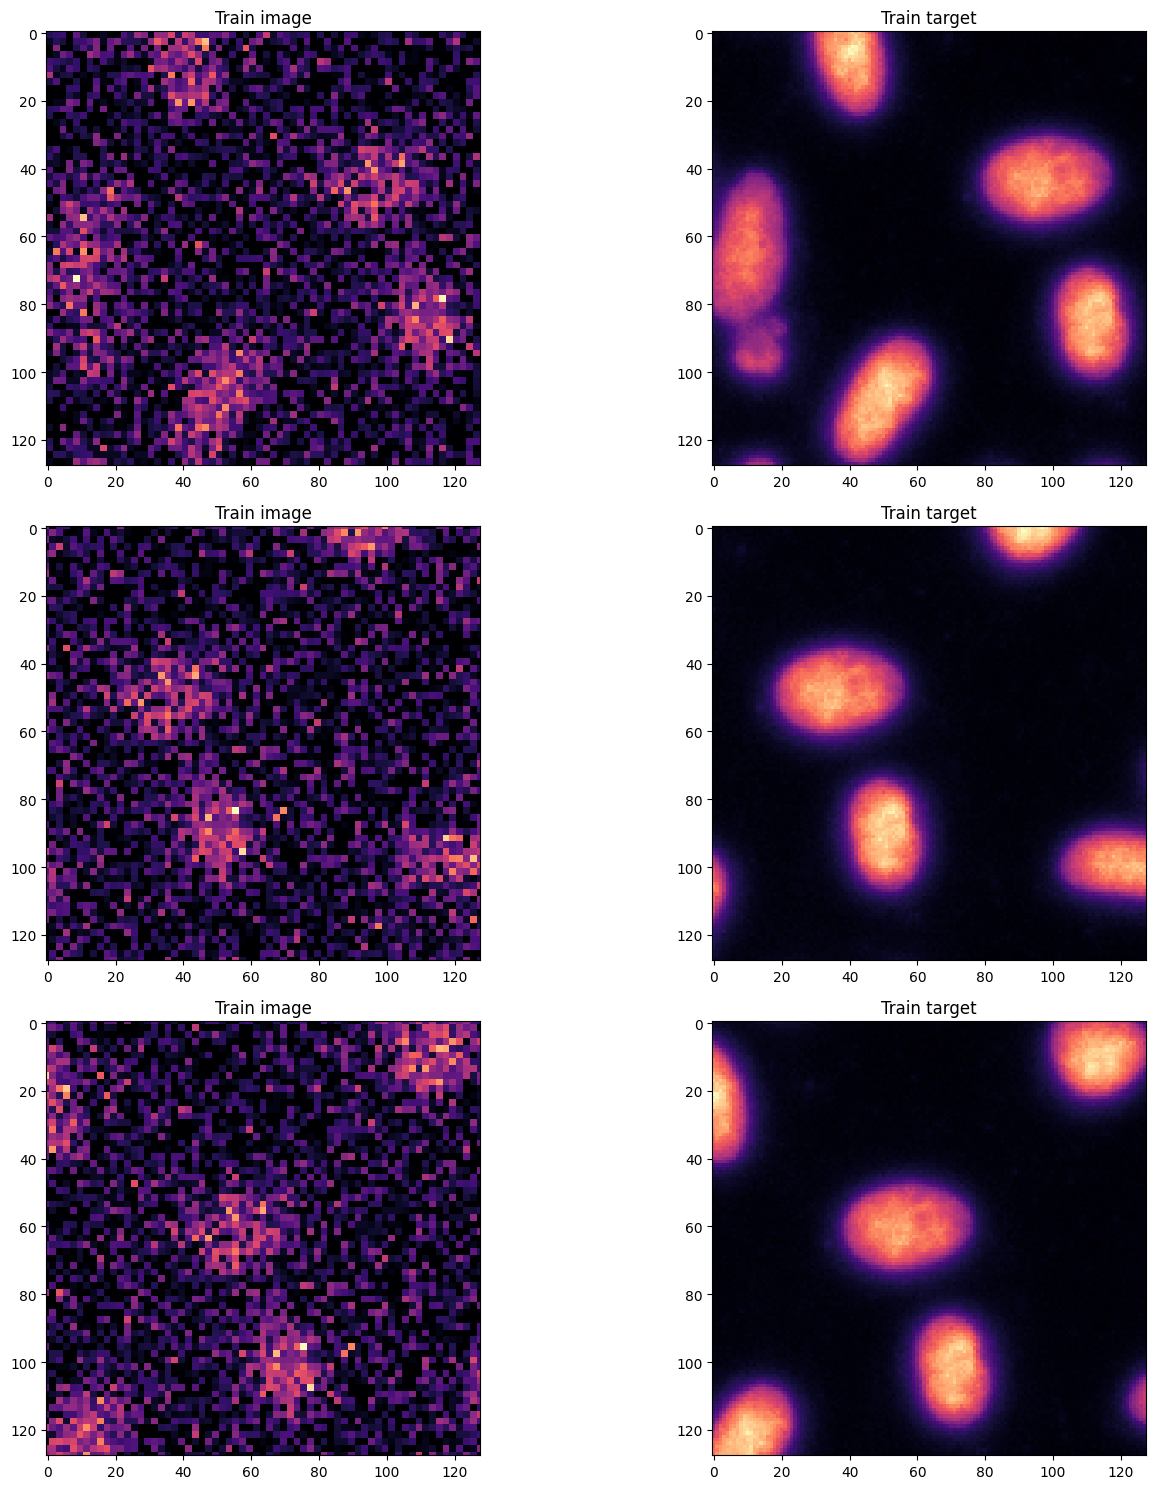

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0, 0].imshow(train_images_patches[0], cmap="magma")
ax[0, 0].set_title("Train image")
ax[0, 1].imshow(train_targets_patches[0], cmap="magma")
ax[0, 1].set_title("Train target")
ax[1, 0].imshow(train_images_patches[1], cmap="magma")
ax[1, 0].set_title("Train image")
ax[1, 1].imshow(train_targets_patches[1], cmap="magma")
ax[1, 1].set_title("Train target")
ax[2, 0].imshow(train_images_patches[2], cmap="magma")
ax[2, 0].set_title("Train image")
ax[2, 1].imshow(train_targets_patches[2], cmap="magma")
ax[2, 1].set_title("Train target")
plt.tight_layout()

### Dataset class

In modern deep learning library, the data is often wrapped into a class called a `Dataset`. Instances of that class are then used to extract the patches before feeding them to the network.

Here, the class will be wrapped around our pre-computed stacks of patches. Our `CAREDataset` class is built on top of the PyTorch `Dataset` class (we say it "inherits" from `Dataset`, the "parent" class). That means that it has some function hidden from us that are defined in the PyTorch repository, but that we also need to implement specific pre-defined methods, such as `__len__` and `__getitem__`. The advantage is that PyTorch knows what to do with a `Dataset` "child" class, since its behaviour is defined in the `Dataset` class, but we can do operations that are closely related to our own data in the method we implement.

<div class="alert alert-block alert-info"><h3>Task 1a: Compute the correct statistics</h3>

Compute the mean and standard deviation of the training data. We will use these values to normalize the data.

*hint: Think about the why this is important and do you need the separate mean/std for targets*

</div>

<div class="alert alert-block alert-info"><h3>Task 1b: Implement your own Dataset</h3>

Implement the `__len__` method so that it returns the total number of patches.

*hint: At the end of the next cell, we have some commented code that can help you test the functions you implement*

</div>

<div class="alert alert-block alert-info"><h3>Task 1c: Implement your own Dataset</h3>

Implement the `__getitem__` method. It should do the following:

1. Extract a patch pair from the stack using the index `index`
2. Apply the augmentation to the patch pair if `apply_augmentation` is `True` using `augment_batch(image, target)`
3. Normalize the patch pair using the `normalize(array, mean, std)` method
4. Return the patch pair as a `float32` image with an additional singleton axis: shape (1, height, width)

*hint: for point 4, remember numpy `array.astype`, `np.float32` and `np.newaxis`.*
</div>

In [24]:
# Calculate the mean and std of the train dataset
train_mean = train_images_array.mean()
train_std = train_images_array.std()
target_mean = train_targets_array.mean()
target_std = train_targets_array.std()
print(f"Train mean: {train_mean}, std: {train_std}")
print(f"Target mean: {target_mean}, std: {target_std}")

Train mean: 10.410432445729962, std: 11.972047125911775
Target mean: 292.29289865275376, std: 289.9138302144558


In [25]:
# Define a Dataset
class CAREDataset(Dataset): # CAREDataset inherits from the PyTorch Dataset class
    def __init__(
        self, image_data: np.ndarray, target_data: np.ndarray, apply_augmentations=False
    ):
        # these are the "members" of the CAREDataset
        self.image_data = image_data
        self.target_data = target_data
        self.patch_augment = apply_augmentations

    def __len__(self):
        """Return the total number of patches.
        
        This method is called when applying `len(...)` to an instance of our class
        """
        return self.image_data.shape[
            0
        ]  # Your code here, define the total number of patches

    def __getitem__(self, index):
        """Return a single pair of patches.
        
        """
        # Your code here, return the patch and target patch, 
        # apply augmentations with a condition. Hint: use the augment_batch function
        # apply the normalize function to the patch and target patch
        # return the patch and target patch. Hint: check the dimensions and the datatype

        # get patch
        patch = self.image_data[index]

        # get target
        target = self.target_data[index]

        # Apply transforms
        if self.patch_augment:
            patch, target = augment_batch(patch=patch, target=target)

        # Normalize the patch
        patch = normalize(patch, train_mean, train_std)
        target = normalize(target, target_mean, target_std)

        return patch[np.newaxis].astype(np.float32), target[np.newaxis].astype(
            np.float32
        )

# test the dataset
train_dataset = CAREDataset(
    image_data=train_images_patches, target_data=train_targets_patches
)

<div class="alert alert-block alert-info"><h3>Check the Dataset</h3>

Run the cell below to make sure your dataset class is working correctly.

If any of the tests fail, go back to the previous cell and fix the issue.
</div>

In [26]:
# what is the dataset length?
assert len(train_dataset) == train_images_patches.shape[0], "Dataset length is wrong"

# check the normalization
assert train_dataset[42][0].max() <= 5, "Patch isn't normalized properly"
assert train_dataset[42][1].max() <= 5, "Target patch isn't normalized properly"

# check the get_item function
assert train_dataset[42][0].shape == (1, *patch_size), "Patch size is wrong"
assert train_dataset[42][1].shape == (1, *patch_size), "Target patch size is wrong"
assert train_dataset[42][0].dtype == np.float32, "Patch dtype is wrong"
assert train_dataset[42][1].dtype == np.float32, "Target patch dtype is wrong"


In [27]:
# Instantiate the dataset and create a DataLoader
train_dataset = CAREDataset(
    image_data=train_images_patches, target_data=train_targets_patches
)
val_dataset = CAREDataset(
    image_data=val_images_patches, target_data=val_targets_patches
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

<div class="alert alert-block alert-success"><h1>Checkpoint 1: Data</h1>
</div>

<hr style="height:2px;">

## Part 2: Training the model

Image restoration task is very similar to the semantic segmentation task we have done in the previous exercise. We can use the same UNet model and just need to adapt a few things.


![image](nb_data/carenet.png)

### Instantiate the model

We'll be using the model from the previous exercise, so we need to load the relevant module

In [31]:
# These lines import the UNet model from the segmentation exercise
import importlib.util
import os

path_to_module = 'projects/dl_courses' # Change this to the path where you downloaded the segmentation exercise


unet_spec = importlib.util.spec_from_file_location(
    "segm", f"/home/{os.environ['USER']}/{path_to_module}/01_segmentation/unet.py"
)
unet_module = importlib.util.module_from_spec(unet_spec)
unet_spec.loader.exec_module(unet_module)

In [32]:
# Load the model
model = unet_module.UNet(depth=3, in_channels=1, out_channels=1)

<div class="alert alert-block alert-info"><h3>Task 2: Loss function</h3>

CARE trains image to image, therefore we need a different loss function compared to the segmentation task (image to mask). Can you think of a suitable loss function?

*hint: look in the `nn` module of PyTorch ([link](https://pytorch.org/docs/stable/nn.html#loss-functions)).*

</div>

<div class="alert alert-block alert-info"><h3>Task 3: Optimizer</h3>

Similarly, define the optimizer. No need to be too inventive here!

</div>

In [33]:
loss = nn.MSELoss()  # Your code here, define the loss function, hint: think about the suitable loss function
optimizer = optim.Adam(
    model.parameters(), lr=1e-4
)  # Your code here, define the optimizer

### Training

Here we will train a CARE model using classes and functions you defined in the previous tasks.
We're using the same training loop as in the semantic segmentation exercise.


In [34]:
# Training loop
n_epochs = 10
device = "cuda" if cuda.is_available() else "cpu"
model.to(device)

# tensorboard
tb_logger = SummaryWriter("runs/Unet"+datetime.now().strftime('%d%H-%M%S'))

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    for i, (image_batch, target_batch) in enumerate(train_dataloader):
        batch = image_batch.to(device)
        target = target_batch.to(device)

        optimizer.zero_grad()
        output = model(batch)
        train_loss = loss(output, target)
        train_loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {train_loss.item()}")

    model.eval()
    
    with no_grad():
        val_loss = 0
        for i, (batch, target) in enumerate(val_dataloader):
            batch = batch.to(device)
            target = target.to(device)

            output = model(batch)
            val_loss = loss(output, target)

        # log tensorboard
        step = epoch * len(train_dataloader)
        tb_logger.add_scalar(tag="train_loss", scalar_value=train_loss, global_step=step)
        tb_logger.add_scalar(tag="val_loss", scalar_value=val_loss, global_step=step)

        # we always log the last validation images
        tb_logger.add_images(tag="val_input", img_tensor=batch.to("cpu"), global_step=step)
        tb_logger.add_images(tag="val_target", img_tensor=target.to("cpu"), global_step=step)
        tb_logger.add_images(
            tag="val_prediction", img_tensor=output.to("cpu"), global_step=step
        )

        print(f"Validation loss: {val_loss.item()}")

    # Save the losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())


Epoch: 0, Batch: 0, Loss: 3.7805309295654297
Epoch: 0, Batch: 10, Loss: 0.13435301184654236
Epoch: 0, Batch: 20, Loss: 0.10186517238616943
Epoch: 0, Batch: 30, Loss: 0.07867030799388885
Epoch: 0, Batch: 40, Loss: 0.07313496619462967
Epoch: 0, Batch: 50, Loss: 0.09755164384841919
Epoch: 0, Batch: 60, Loss: 0.07651880383491516
Epoch: 0, Batch: 70, Loss: 0.05804198235273361
Epoch: 0, Batch: 80, Loss: 0.05455797538161278
Epoch: 0, Batch: 90, Loss: 0.04842102900147438
Epoch: 0, Batch: 100, Loss: 0.0620805025100708
Epoch: 0, Batch: 110, Loss: 0.07139509171247482
Epoch: 0, Batch: 120, Loss: 0.058541156351566315
Epoch: 0, Batch: 130, Loss: 0.05446302518248558
Epoch: 0, Batch: 140, Loss: 0.05293302237987518
Epoch: 0, Batch: 150, Loss: 0.0554867684841156
Epoch: 0, Batch: 160, Loss: 0.05904882773756981
Epoch: 0, Batch: 170, Loss: 0.043607816100120544
Epoch: 0, Batch: 180, Loss: 0.03987054526805878
Epoch: 0, Batch: 190, Loss: 0.052315108478069305
Epoch: 0, Batch: 200, Loss: 0.04431714862585068
Epo

### Plot the loss

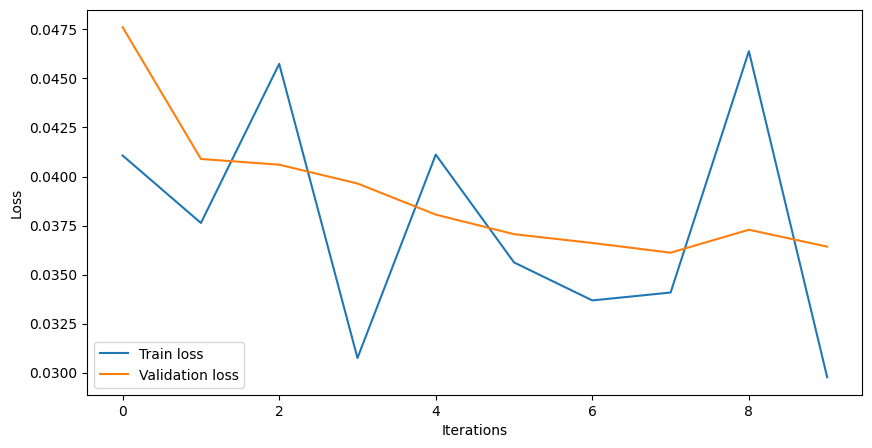

In [36]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(["Train loss", "Validation loss"])


<div class="alert alert-block alert-success"><h1>Checkpoint 2: Training</h1>
</div>

<hr style="height:2px;">

## Part 3: Predicting on the test dataset


In [37]:
# Define the dataset for the test data
test_dataset = CAREDataset(
    image_data=test_images_array, target_data=test_targets_array
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [38]:
# Define the prediction loop

test_images = []
predictions = []

model.eval()
with no_grad():
    for i, (image_batch, target_batch) in enumerate(test_dataloader):
        image_batch = image_batch.to(device)
        target_batch = target_batch.to(device)
        output = model(image_batch)

        # Save the images and predictions for visualization
        test_images.append(denormalize(image_batch.cpu().numpy(), train_mean, train_std))
        predictions.append(denormalize(output.cpu().numpy(), train_mean, train_std))

### Visualize the predictions

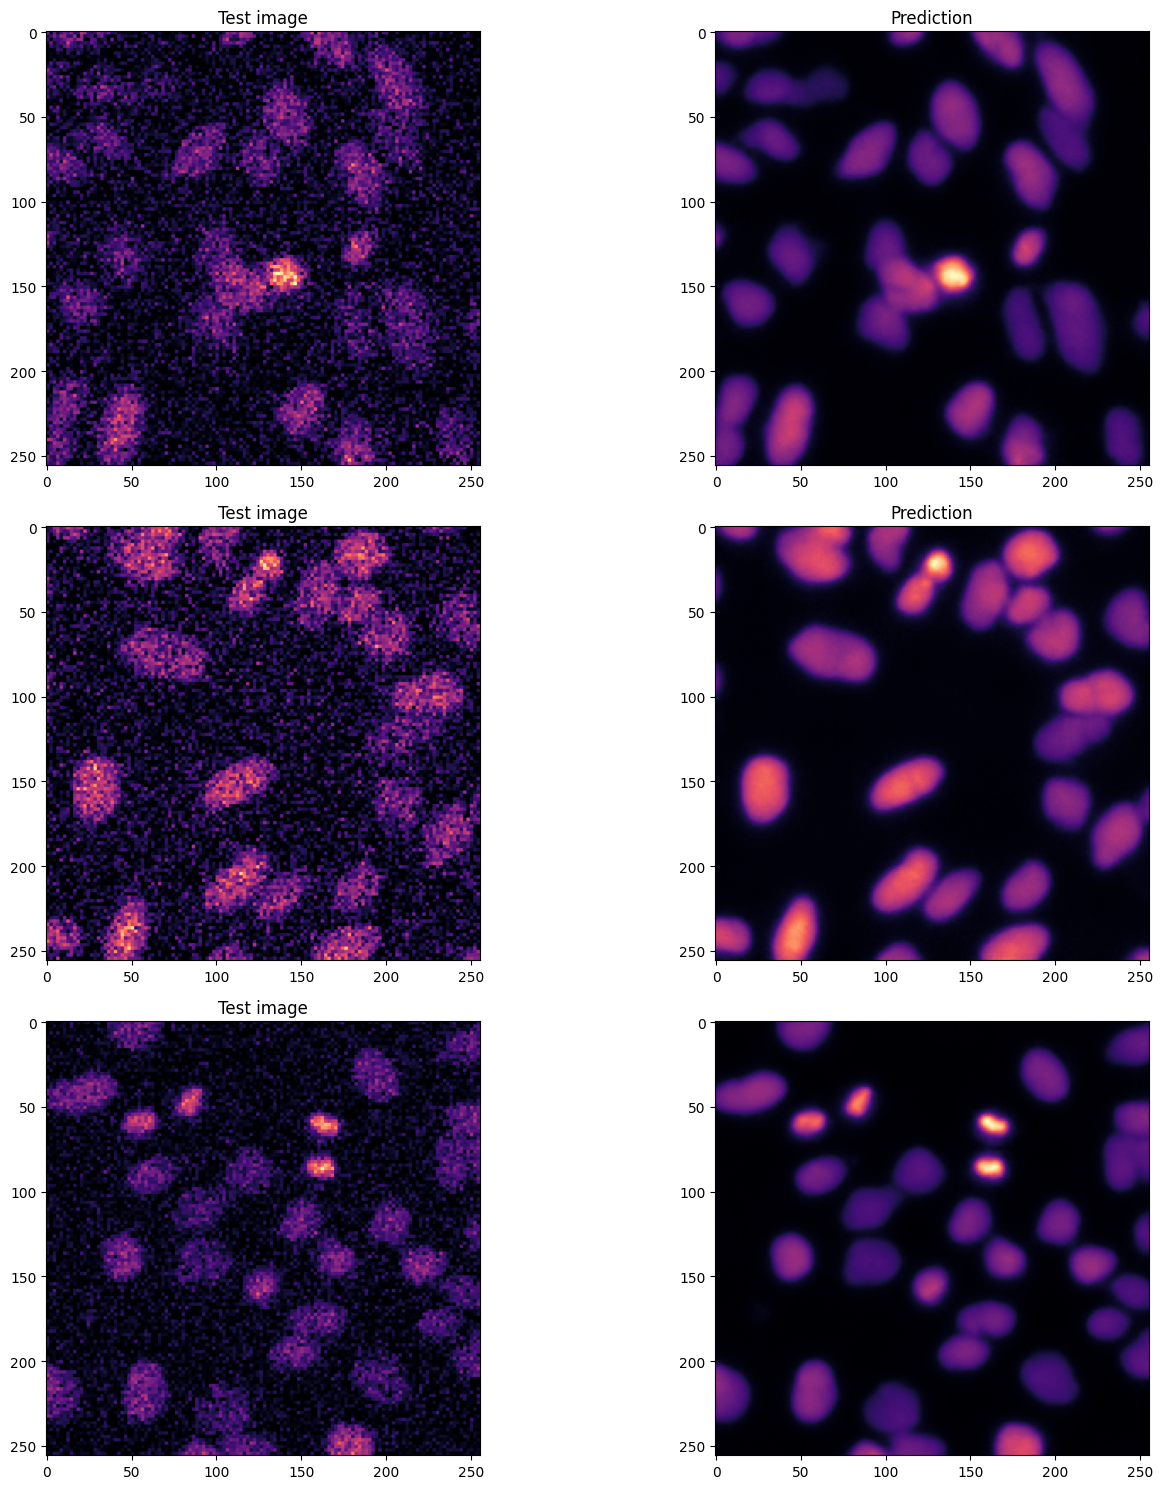

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0, 0].imshow(test_images[0][0].squeeze(), cmap="magma")
ax[0, 0].set_title("Test image")
ax[0, 1].imshow(predictions[0][0].squeeze(), cmap="magma")
ax[0, 1].set_title("Prediction")
ax[1, 0].imshow(test_images[1][0].squeeze(), cmap="magma")
ax[1, 0].set_title("Test image")
ax[1, 1].imshow(predictions[1][0].squeeze(), cmap="magma")
ax[1, 1].set_title("Prediction")
ax[2, 0].imshow(test_images[2][0].squeeze(), cmap="magma")
ax[2, 0].set_title("Test image")
ax[2, 1].imshow(predictions[2][0].squeeze(), cmap="magma")
plt.tight_layout()

<div class="alert alert-block alert-success"><h1>Checkpoint 3: Predicting</h1>
</div>